In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.fft import rfft,rfftfreq,irfft
from scipy import stats
from scipy.stats import norm 
from pandas import set_option
from matplotlib import ticker

In [2]:
data = pd.read_csv('D:\ljw\课程\商务数据分析\大作业\walmart_cleaned.csv')
## https://www.datacastle.cn/dataset_description.html?type=dataset&id=1779

### 数据基本信息

#### data.info()

In [4]:
"""
店铺 - 店铺编号
日期 - 销售周
WeeklySales - 给定商店的销售额
HolidayFlag - 该周是否为特殊假日周 1 – 假日周 0 – 非假日周
温度 - 销售当天的温度
Fuel_Price - 该地区的燃料成本
CPI – 现行消费物价指数
失业率 - 现行失业率
Markdown - 与沃尔玛促销降价相关的匿名数据，仅在 2011 年 11 月之后可用，并非一直适用于所有商店
节日活动：

超级碗：2010 年 2 月 12 日、11 年 2 月 11 日、12 年 2 月 10 日、13 年 2 月 8 日\
劳动节：10-Sep-10、9-Sep-11、7-Sep-12、6-Sep-13\
感恩节：2010 年 11 月 26 日、11 年 11 月 25 日、12 年 11 月 23 日、13 年 11 月 29 日\
圣诞节：2010 年 12 月 31 日、2011 年 12 月 30 日、12 年 12 月 28 日、13 年 12 月 27 日
"""

data.head(10)

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2010/2/5,0,1,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,2010/2/5,0,26,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,1,2010/2/5,0,17,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,1,2010/2/5,0,45,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,1,2010/2/5,0,28,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
5,1,2010/2/5,0,79,46729.77,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
6,1,2010/2/5,0,55,21249.31,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
7,1,2010/2/5,0,5,32229.38,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
8,1,2010/2/5,0,58,7659.97,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
9,1,2010/2/5,0,7,21084.08,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


### 数据清理

In [5]:
## 去除小于等于0的数据
nlist = ["Dept","Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment","Type","Size"]
for cname in nlist:
    c = data[[cname]]  
    c[c <= 0] = np.nan
    data[[cname]] = c
data = data.dropna(axis=0, how='any')

In [6]:
## 去除重复的数据
data.drop_duplicates( keep='first', inplace=True)
odata = data

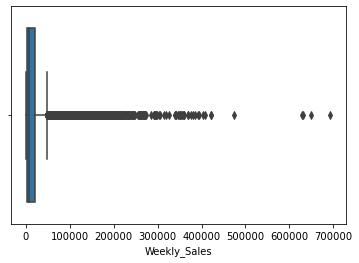

In [7]:
data = odata
## 去除噪声
sns.boxplot(x = data['Weekly_Sales'])  ## 数据太多，箱型图作用不大

### 不同department数据差别很大，需要对于时间序列进行分组处理
def denoise(f_noise):
    yf   = rfft(f_noise)
    yf_abs      = np.abs(yf) 
    indices     = yf_abs>300   # filter out those value under 300
    yf_clean    = indices * yf # noise frequency will be set to 0
    new_f_clean = irfft(yf_clean)
    return(list(new_f_clean))


groups = list(data.groupby(data.Dept))
i = 0
for x in groups:
    tmp_df = x[1]
    try:
        c = tmp_df['Weekly_Sales']
        c = denoise(list(c))
        c = pd.Series(c,index = list(tmp_df['Weekly_Sales'].index))
        tmp_df['Weekly_Sales'] = c
    except:
        pass
    
    if i==0:
        res_df = tmp_df
    else:
        res_df = pd.concat([res_df,tmp_df])
       
    i += 1
    
data = res_df.reset_index(drop=True)

In [8]:
### 对比：直接用QR计算处理，去除离群点，在时间序列中是不合理的

def newdenoise(x):
    #计算四分位点
    a = np.array(x) 
    x = list(x)
    q1 = np.percentile(a, 25)  
    q3 = np.percentile(a, 75)  
    iqr = q3 - q1

    # 找出异常值
    for i in range(len(x)): 
        # 在正常值范围内时 i+1
        if x[i] > q3 + (1.5*iqr) or x[i] < q1 - (1.5*iqr):   
            x[i] = np.nan
    
    return(pd.DataFrame(x))


groups = list(data.groupby(data.Dept))
i = 0
for x in groups:
    tmp_df = x[1]
    c = tmp_df['Weekly_Sales']
    c = newdenoise(c)
    tmp_df['Weekly_Sales'] = c
    tmp_df = tmp_df.dropna(axis=0, how='any')
    
    if i==0:
        newres_df = tmp_df
    else:
        newres_df = pd.concat([newres_df,tmp_df])
    i += 1

new_data = newres_df

In [9]:
## 清洗过后的数据
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420145 entries, 0 to 420144
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420145 non-null  int64  
 1   Date          420145 non-null  object 
 2   IsHoliday     420145 non-null  int64  
 3   Dept          420145 non-null  int64  
 4   Weekly_Sales  420145 non-null  float64
 5   Temperature   420145 non-null  float64
 6   Fuel_Price    420145 non-null  float64
 7   MarkDown1     420145 non-null  float64
 8   MarkDown2     420145 non-null  float64
 9   MarkDown3     420145 non-null  float64
 10  MarkDown4     420145 non-null  float64
 11  MarkDown5     420145 non-null  float64
 12  CPI           420145 non-null  float64
 13  Unemployment  420145 non-null  float64
 14  Type          420145 non-null  int64  
 15  Size          420145 non-null  int64  
dtypes: float64(10), int64(5), object(1)
memory usage: 51.3+ MB


In [10]:
data.to_csv(r"new_cleaned_data.csv",index=False)
odata = data

In [11]:
## 对比，清洗过后的数据
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6024 entries, 0 to 6433
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6024 non-null   int64  
 1   Date          6024 non-null   object 
 2   IsHoliday     6024 non-null   int64  
 3   Dept          6024 non-null   int64  
 4   Weekly_Sales  6024 non-null   float64
 5   Temperature   6024 non-null   float64
 6   Fuel_Price    6024 non-null   float64
 7   MarkDown1     6024 non-null   float64
 8   MarkDown2     6024 non-null   float64
 9   MarkDown3     6024 non-null   float64
 10  MarkDown4     6024 non-null   float64
 11  MarkDown5     6024 non-null   float64
 12  CPI           6024 non-null   float64
 13  Unemployment  6024 non-null   float64
 14  Type          6024 non-null   int64  
 15  Size          6024 non-null   int64  
dtypes: float64(10), int64(5), object(1)
memory usage: 800.1+ KB


### 简要统计分析

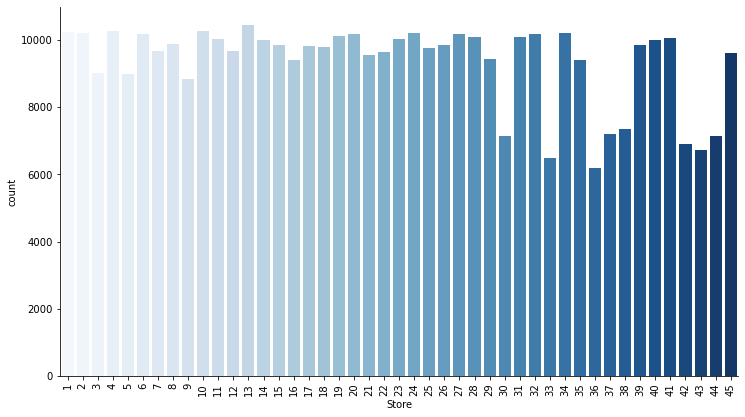

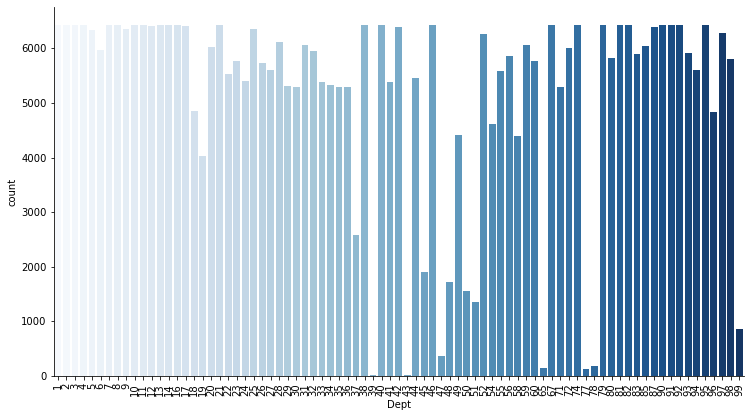

In [12]:
for feat in ['Store', 'Dept']:
    ax = sns.catplot(x= feat, kind = "count", palette="Blues",data=data)
    ax.figure.set_size_inches(12,6)
    plt.xticks(rotation=90)

In [13]:
## 基础统计指标
set_option('display.width', 100)
set_option('precision', 3)
description = data.describe()
print(description)

            Store   IsHoliday        Dept  Weekly_Sales  Temperature  Fuel_Price   MarkDown1  \
count  420145.000  420145.000  420145.000    420145.000   420145.000  420145.000  420145.000   
mean       22.198       0.070      44.241     16034.343       60.101       3.361    2590.737   
std        12.787       0.256      30.509     22730.682       18.433       0.459    6053.810   
min         1.000       0.000       1.000         0.000        5.540       2.472       0.000   
25%        11.000       0.000      18.000      2120.420       46.700       2.933       0.000   
50%        22.000       0.000      37.000      7662.780       62.090       3.452       0.000   
75%        33.000       0.000      74.000     20273.710       74.290       3.738    2809.050   
max        45.000       1.000      99.000    693099.360      100.140       4.468   88646.760   

        MarkDown2   MarkDown3   MarkDown4   MarkDown5         CPI  Unemployment        Type  \
count  420145.000  420145.000  420145.00

Skewness:  3.2587935418500567
Kurtosis:  21.458826024961912


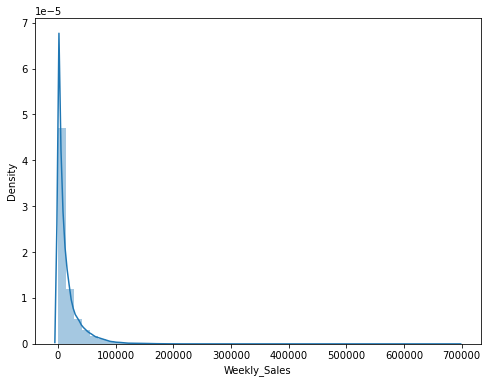

In [14]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(data['Weekly_Sales'])
print("Skewness: ", data['Weekly_Sales'].skew()) #skewness
print("Kurtosis: ", data['Weekly_Sales'].kurt()) #kurtosis

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

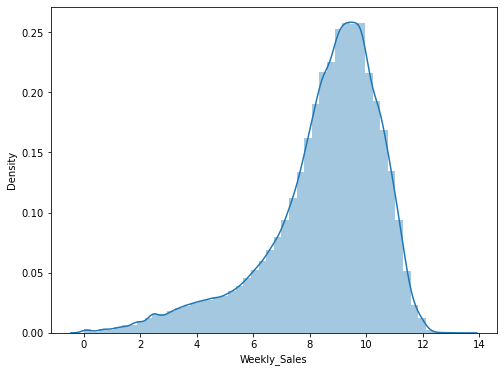

In [15]:
sales_over_zero = np.log1p(data['Weekly_Sales'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(sales_over_zero)

(11055, 16)
   Dept        Date  Store  IsHoliday  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0     1   2010/10/1   23.0        0.0       16981.0         70.0         3.0        0.0   
1     1  2010/10/15   23.0        0.0       21815.0         61.0         3.0        0.0   
2     1  2010/10/22   23.0        0.0       25127.0         59.0         3.0        0.0   
3     1  2010/10/29   23.0        0.0       39135.0         59.0         3.0        0.0   
4     1   2010/10/8   23.0        0.0       19767.0         62.0         3.0        0.0   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5    CPI  Unemployment  Type      Size  
0        0.0        0.0        0.0        0.0  168.0           8.0   2.0  130288.0  
1        0.0        0.0        0.0        0.0  168.0           8.0   2.0  130288.0  
2        0.0        0.0        0.0        0.0  169.0           8.0   2.0  130288.0  
3        0.0        0.0        0.0        0.0  169.0           8.0   2.0  130288.0  
4        0.0    

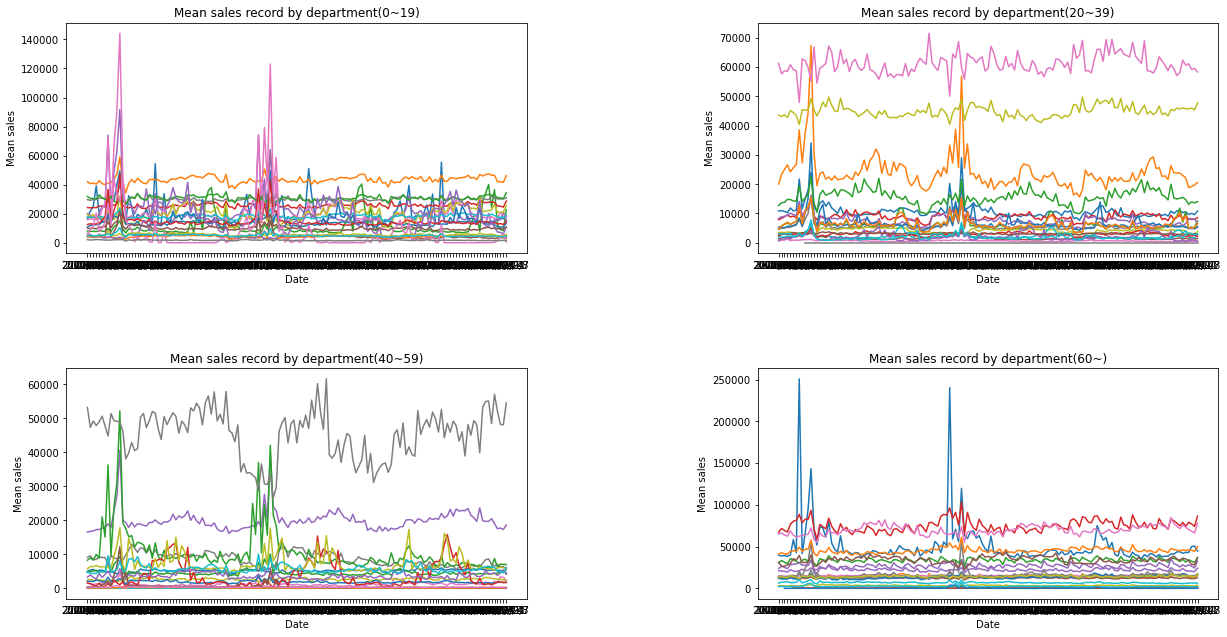

'\n销量水平因部门而异，同一个部门的销量稳定\n一月和五月左右有一些高峰，可能是因为某些事件\n\n结论1：部门是预测销售额的一个很好的特征\n结论2：日期（尤其是事件）是预测销售的一个很好的特征\n'

In [16]:
grouped = data.groupby(['Dept','Date']).mean().round(0).reset_index()
print(grouped.shape)
print(grouped.head())
data = grouped[['Dept','Date','Weekly_Sales']]

dept = data['Dept'].unique()
dept.sort()
dept_1 = dept[0:20]
dept_2 = dept[20:40]
dept_3 = dept[40:60]
dept_4 = dept[60:]

fig, ax = plt.subplots(2,2,figsize=(20,10))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

for i in dept_1 :
    data_1=data[data['Dept']==i]
    ax[0,0].plot(data_1['Date'], data_1['Weekly_Sales'],label='Dept_1_mean_sales')

for i in dept_2 :
    data_1=data[data['Dept']==i]
    ax[0,1].plot(data_1['Date'], data_1['Weekly_Sales'],label='Dept_1_mean_sales')
    
for i in dept_3 :
    data_1=data[data['Dept']==i]
    ax[1,0].plot(data_1['Date'], data_1['Weekly_Sales'],label='Dept_1_mean_sales')   
for i in dept_4 :
    data_1=data[data['Dept']==i]
    ax[1,1].plot(data_1['Date'], data_1['Weekly_Sales'],label='Dept_1_mean_sales')        
    
ax[0,0].set_title('Mean sales record by department(0~19)')
ax[0,1].set_title('Mean sales record by department(20~39)')
ax[1,0].set_title('Mean sales record by department(40~59)')
ax[1,1].set_title('Mean sales record by department(60~)')

ax[0,0].set_ylabel('Mean sales')
ax[0,0].set_xlabel('Date')
ax[0,1].set_ylabel('Mean sales')
ax[0,1].set_xlabel('Date')
ax[1,0].set_ylabel('Mean sales')
ax[1,0].set_xlabel('Date')
ax[1,1].set_ylabel('Mean sales')
ax[1,1].set_xlabel('Date')

plt.show()

"""
销量水平因部门而异，同一个部门的销量稳定
一月和五月左右有一些高峰，可能是因为某些事件

结论1：部门是预测销售额的一个很好的特征
结论2：日期（尤其是事件）是预测销售的一个很好的特征
"""

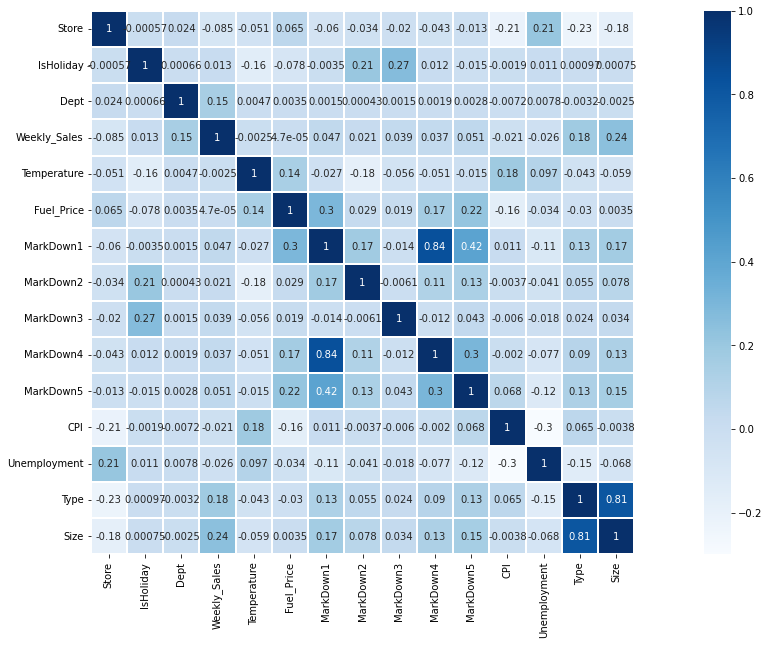

In [17]:
## 相关性，整体
data = odata
plt.figure(figsize=(25, 10))
cor = odata.corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')
plt.show()

### 数据分析过程

<AxesSubplot:>

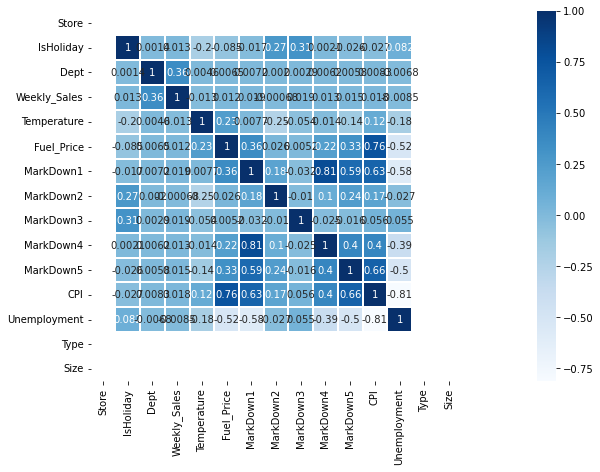

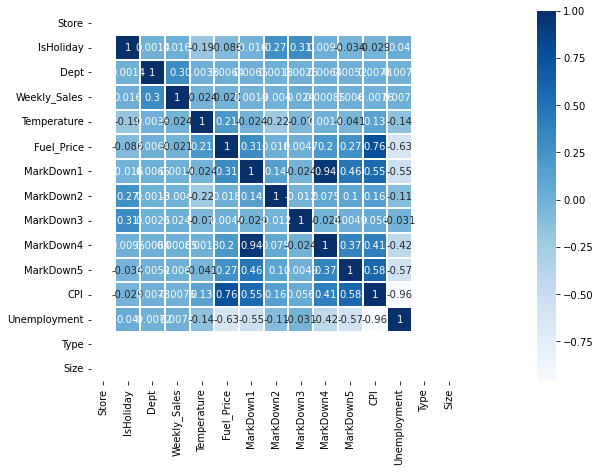

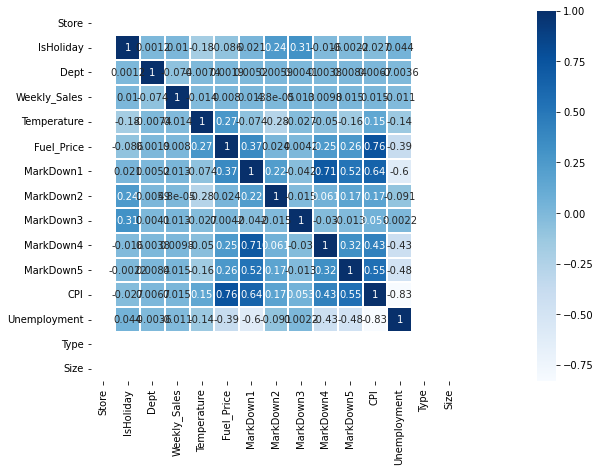

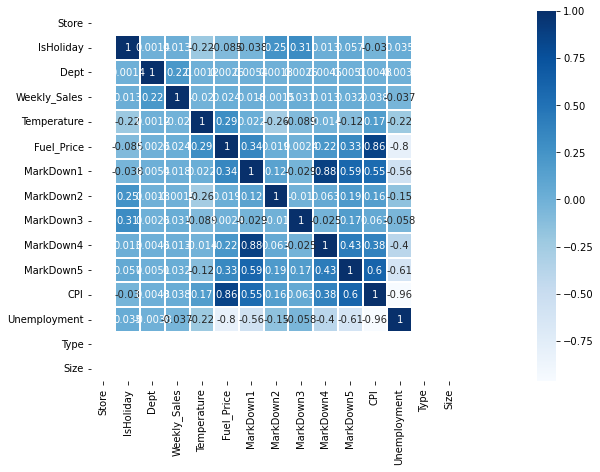

In [18]:
## 分store分析，以前4个为例
groups = list(data.groupby(data.Store))

plt.figure(figsize=(60,15))
ax = plt.subplot(221)
cor = groups[0][1].corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')

plt.figure(figsize=(60,15))
ax = plt.subplot(222)
cor = groups[1][1].corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')

plt.figure(figsize=(60,15))
ax = plt.subplot(223)
cor = groups[2][1].corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')

plt.figure(figsize=(60,15))
ax = plt.subplot(224)
cor = groups[3][1].corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')

In [19]:
for i in range(len(groups)):
    cor = groups[i][1].corr()
    fm = cor['Weekly_Sales'].to_frame(name=str(i))
    if i==0:
        corr_matrix = fm
    else:
        corr_matrix[str(i)] = fm
        
description = corr_matrix.T.describe()
print(description)

       Store  IsHoliday    Dept  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
count    0.0     45.000  45.000          45.0       45.000      45.000  4.500e+01  4.500e+01   
mean     NaN      0.014   0.152           1.0       -0.008      -0.007 -2.701e-04 -4.926e-03   
std      NaN      0.009   0.219           0.0        0.016       0.025  1.569e-02  9.420e-03   
min      NaN     -0.004  -0.225           1.0       -0.050      -0.086 -5.009e-02 -2.664e-02   
25%      NaN      0.010  -0.074           1.0       -0.020      -0.018 -6.570e-03 -9.242e-03   
50%      NaN      0.013   0.226           1.0       -0.008      -0.009  2.912e-03 -4.043e-03   
75%      NaN      0.018   0.300           1.0        0.006       0.011  9.889e-03  4.789e-05   
max      NaN      0.036   0.558           1.0        0.024       0.034  2.786e-02  2.911e-02   

       MarkDown3  MarkDown4  MarkDown5     CPI  Unemployment  Type  Size  
count     45.000  4.500e+01  4.500e+01  45.000     4.500e+01

<AxesSubplot:>

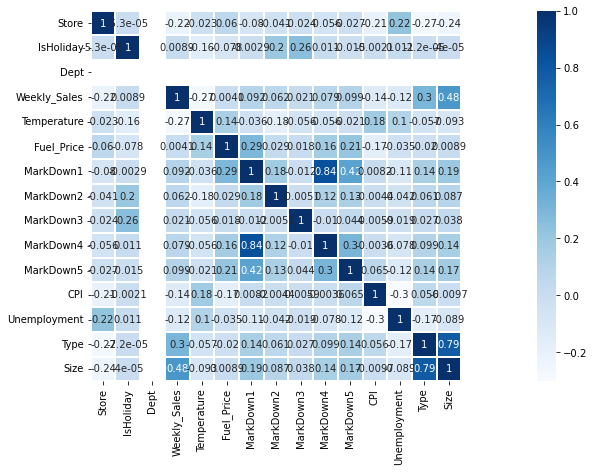

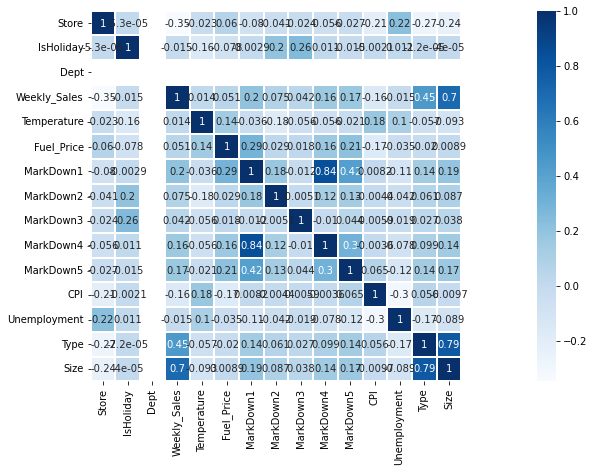

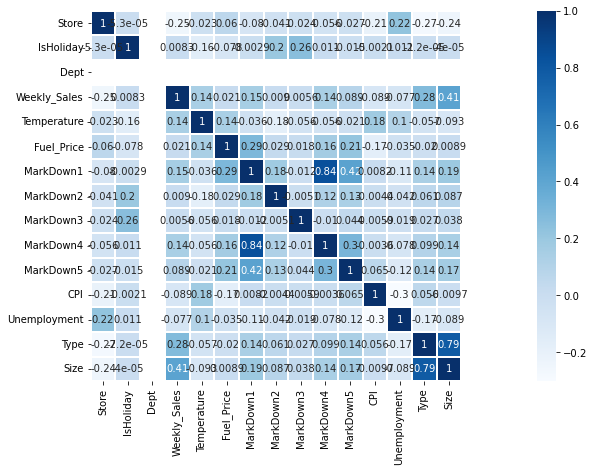

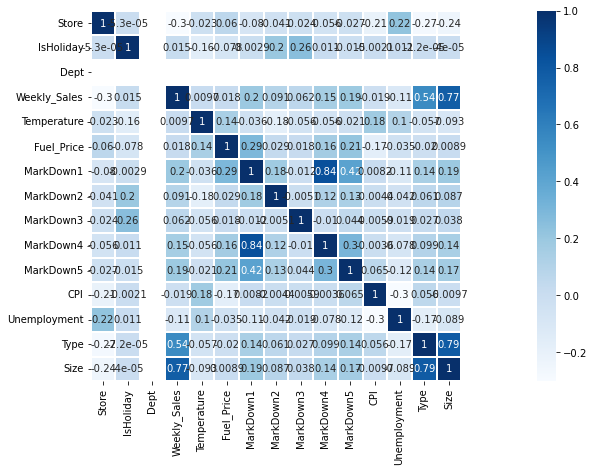

In [20]:
## 分department分析，以前4个为例
groups = list(data.groupby(data.Dept))

plt.figure(figsize=(60,15))
ax = plt.subplot(221)
cor = groups[0][1].corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')

plt.figure(figsize=(60,15))
ax = plt.subplot(222)
cor = groups[1][1].corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')

plt.figure(figsize=(60,15))
ax = plt.subplot(223)
cor = groups[2][1].corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')

plt.figure(figsize=(60,15))
ax = plt.subplot(224)
cor = groups[3][1].corr()
sns.heatmap(cor, square=True, linewidths=0.06, annot=True,cmap='Blues')

In [21]:
for i in range(len(groups)):
    cor = groups[i][1].corr()
    fm = cor['Weekly_Sales'].to_frame(name=str(i))
    if i==0:
        corr_matrix = fm
    else:
        corr_matrix[str(i)] = fm
        
description = corr_matrix.T.describe()
print(description)

        Store  IsHoliday  Dept  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
count  77.000     78.000   0.0          78.0       78.000      78.000     78.000     78.000   
mean   -0.225      0.029   NaN           1.0       -0.024      -0.019      0.079      0.032   
std     0.154      0.098   NaN           0.0        0.143       0.091      0.089      0.067   
min    -0.633     -0.201   NaN           1.0       -0.360      -0.433     -0.297     -0.319   
25%    -0.321     -0.015   NaN           1.0       -0.107      -0.060      0.034      0.002   
50%    -0.225      0.009   NaN           1.0       -0.004      -0.004      0.085      0.035   
75%    -0.099      0.054   NaN           1.0        0.054       0.036      0.139      0.075   
max     0.060      0.590   NaN           1.0        0.314       0.156      0.223      0.136   

       MarkDown3  MarkDown4  MarkDown5     CPI  Unemployment    Type    Size  
count     78.000     78.000     78.000  78.000        78.000  77.

In [22]:
corr_matrix.T.head(5)

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,-0.217,0.009,NaN,1.0,-0.274,0.004,0.092,0.062,0.021,0.079,0.099,-0.136,-0.122,0.301,0.476
1,-0.348,-0.015,NaN,1.0,0.014,0.051,0.201,0.075,0.042,0.160,0.172,-0.158,-0.015,0.451,0.702
2,-0.250,0.008,NaN,1.0,0.143,0.021,0.153,0.009,0.006,0.143,0.089,-0.089,-0.077,0.276,0.413
3,-0.303,0.015,NaN,1.0,0.010,0.018,0.196,0.091,0.062,0.152,0.191,-0.019,-0.114,0.542,0.770
4,-0.335,0.152,NaN,1.0,-0.287,-0.104,0.067,0.088,0.309,0.060,0.092,-0.139,-0.072,0.379,0.521


<AxesSubplot:ylabel='Store'>

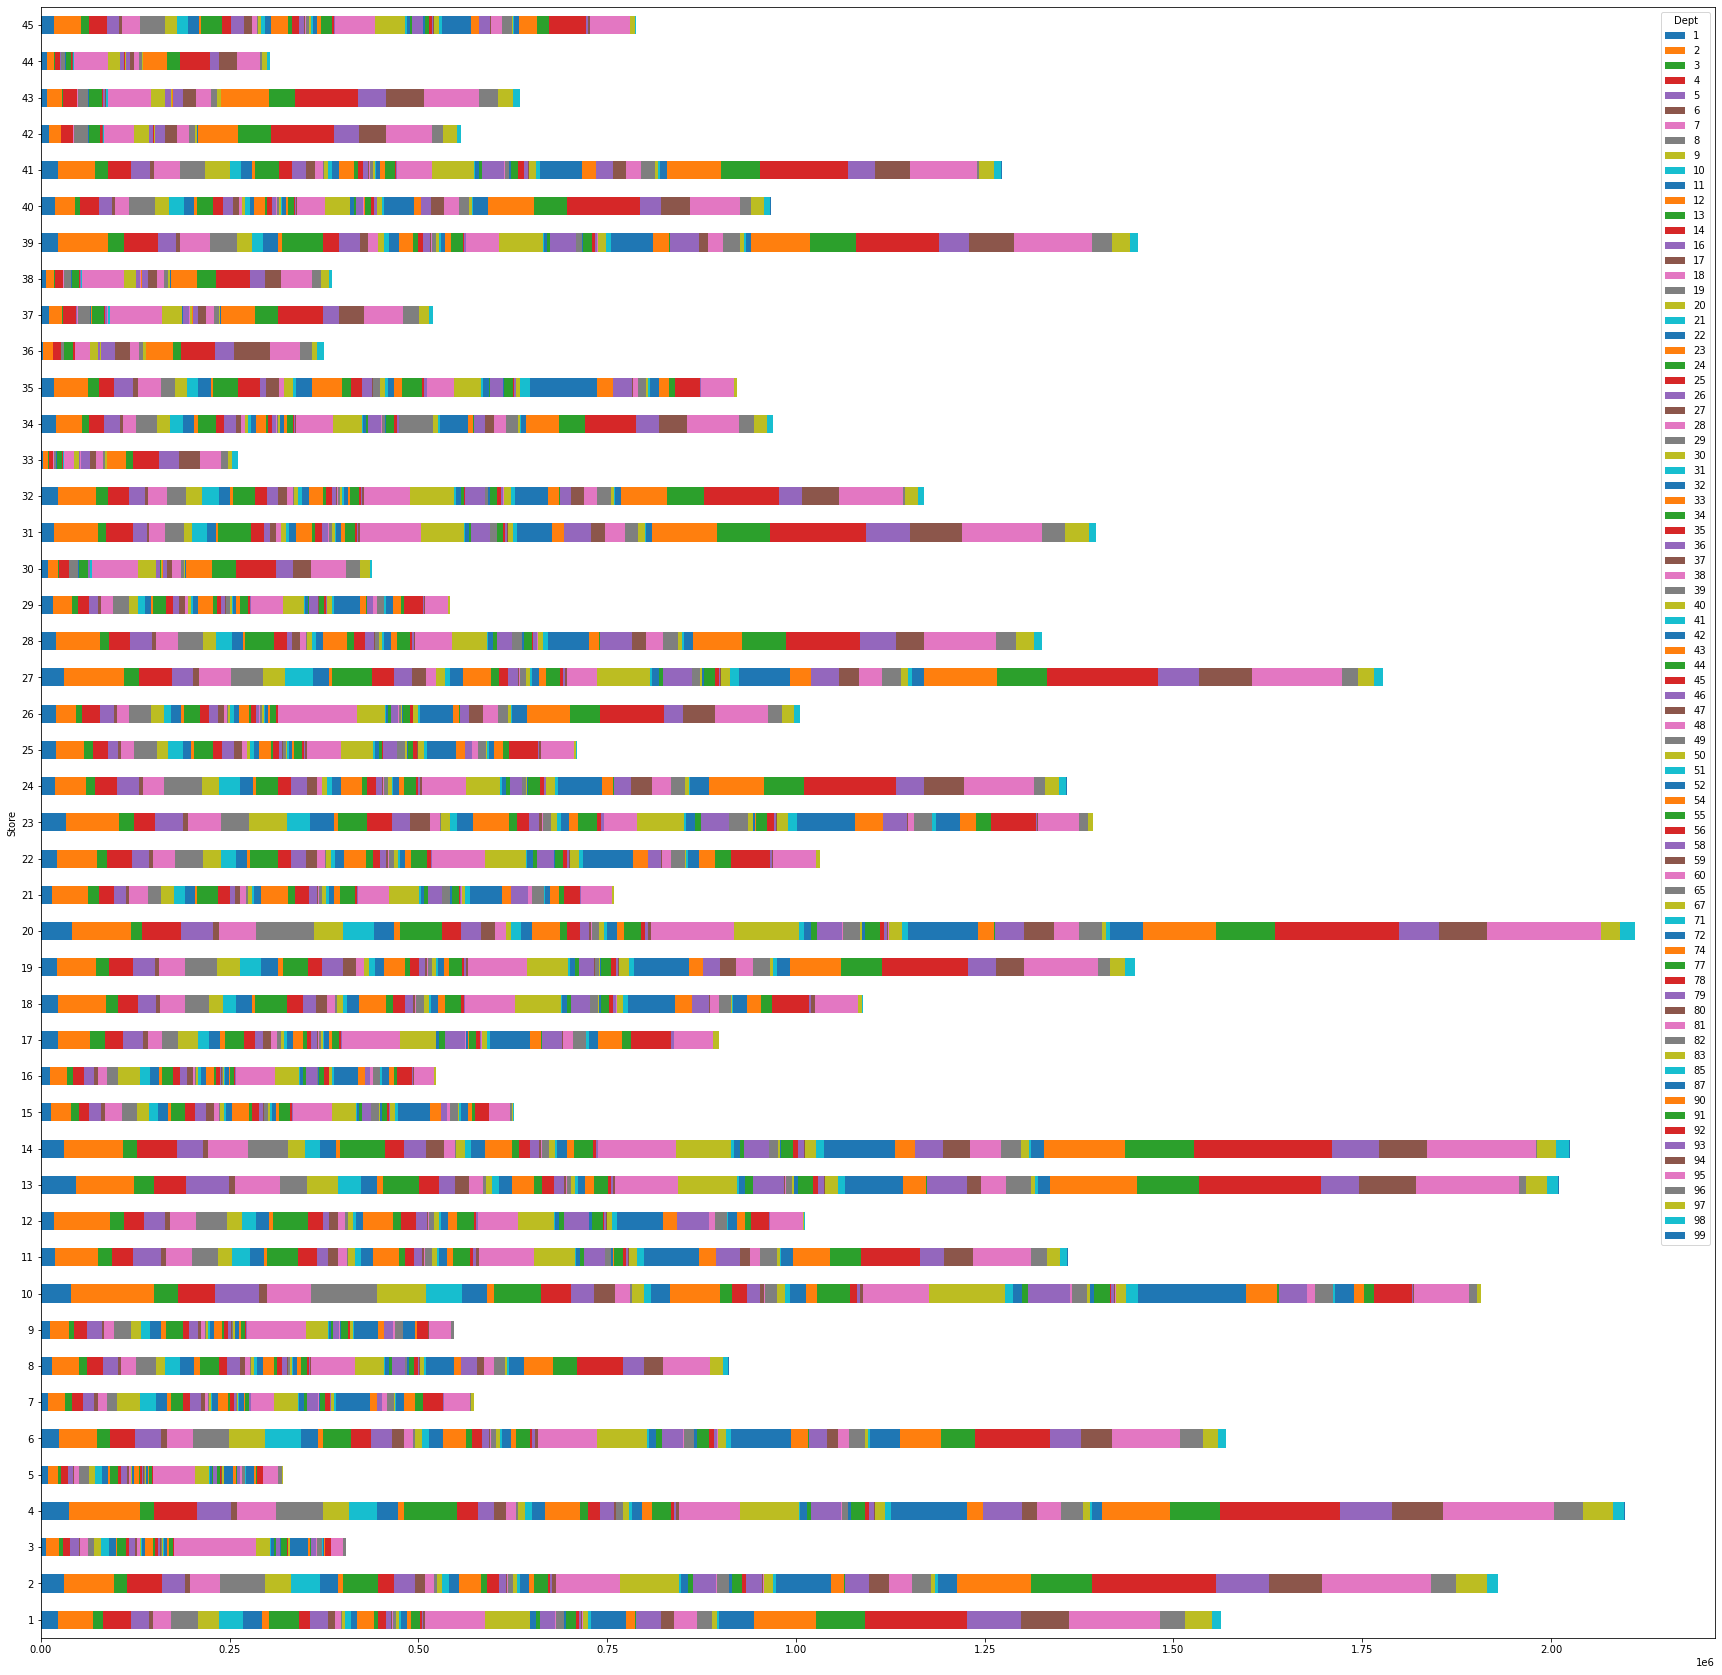

In [28]:
## 透视图
pivot = pd.pivot_table(data, index = "Store", columns='Dept',  values = "Weekly_Sales" )
pivot.plot(kind='barh', stacked=True,figsize=(30,30))

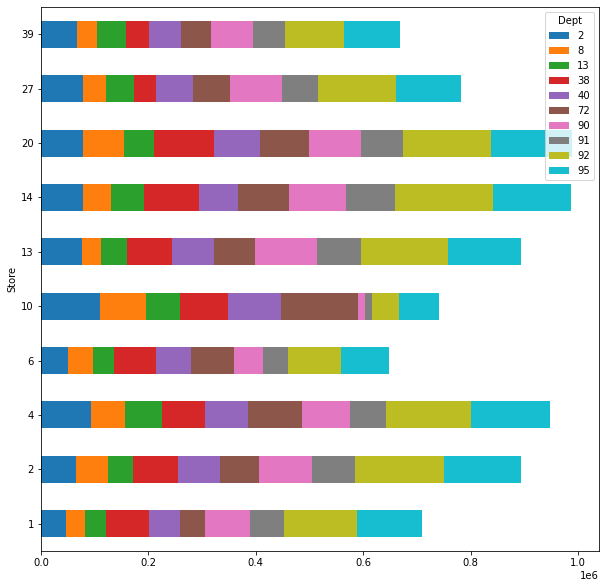

In [29]:
top10_store = data.groupby('Store').Weekly_Sales.sum().nlargest(10)
top10_dept = data.groupby('Dept').Weekly_Sales.sum().nlargest(10)
df = data.loc[data.Store.isin(top10_store.index)].loc[data.Dept.isin(top10_dept.index)]
top10_pivot = pd.pivot_table(df, index = "Store", columns='Dept',  values = "Weekly_Sales" )
ax = top10_pivot.plot(kind='barh', stacked=True,figsize=(10,10))

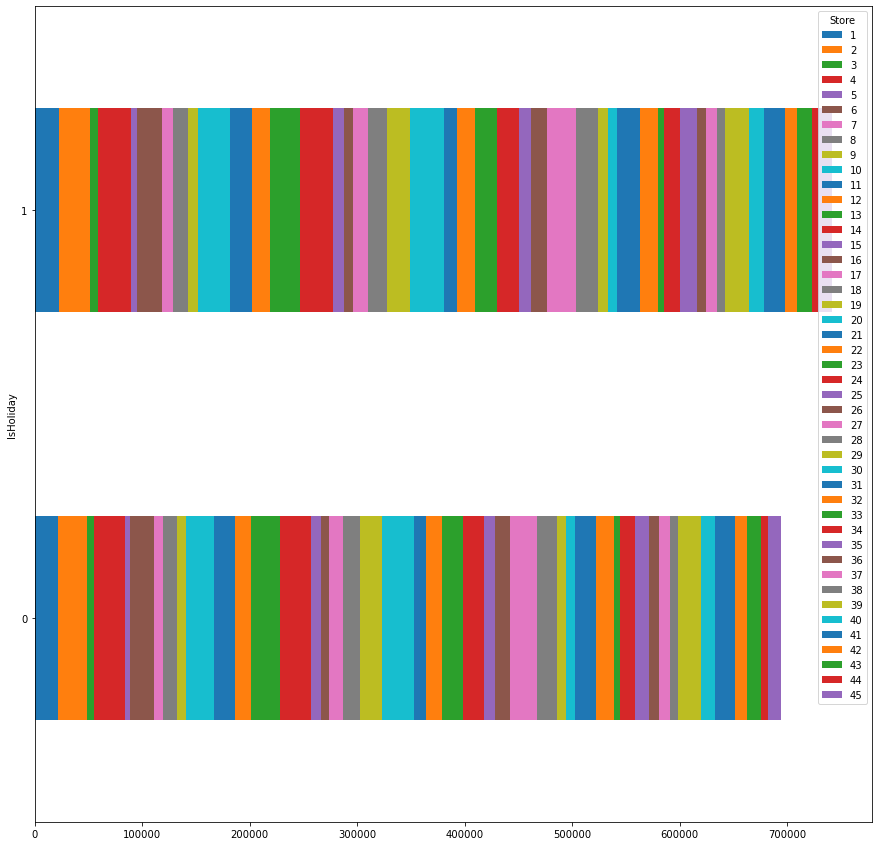

In [33]:
pivot = pd.pivot_table(data, index = "IsHoliday", columns='Store',  values = "Weekly_Sales" )
ax = pivot.plot(
    kind='barh', stacked=True,figsize=(15,15))
plt.savefig('is_holiday.jpg')

In [ ]:
## 心智图
# https://l33azost9g.feishu.cn/mindnotes/bmncnT2dBEOWByrKIqFovBja2Rc#mindmap
# https://l33azost9g.feishu.cn/docs/doccn1hOanoBfqzZ9lCcJwTzQjg

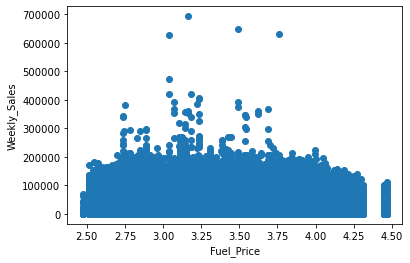

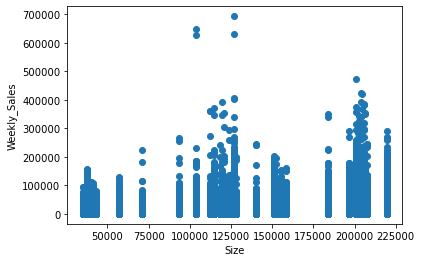

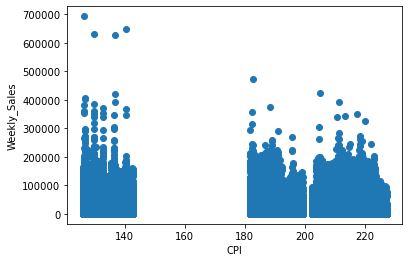

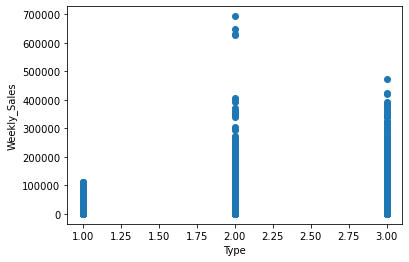

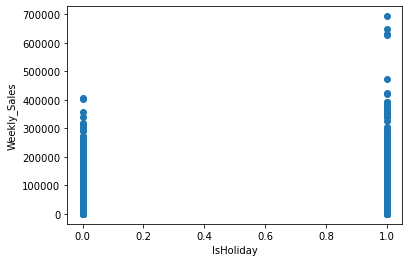

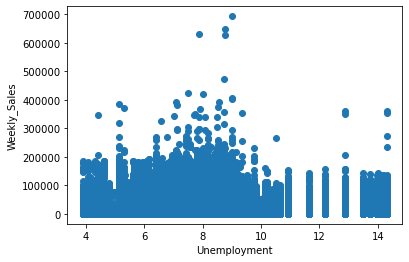

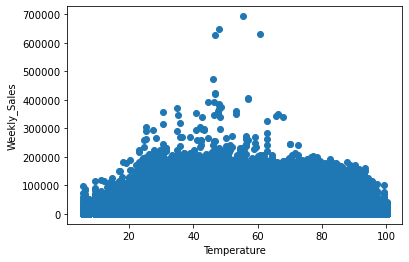

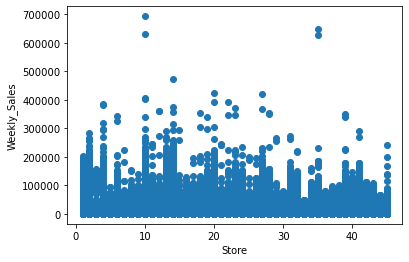

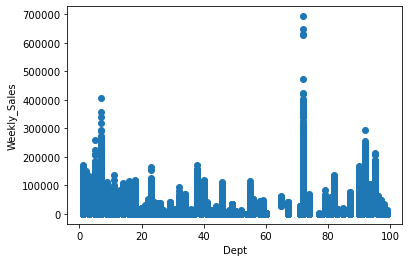

In [34]:
## 各种图表
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column] , dataset['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)
scatter(data, 'Fuel_Price')
scatter(data, 'Size')
scatter(data, 'CPI')
scatter(data, 'Type')
scatter(data, 'IsHoliday')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')
scatter(data, 'Dept')

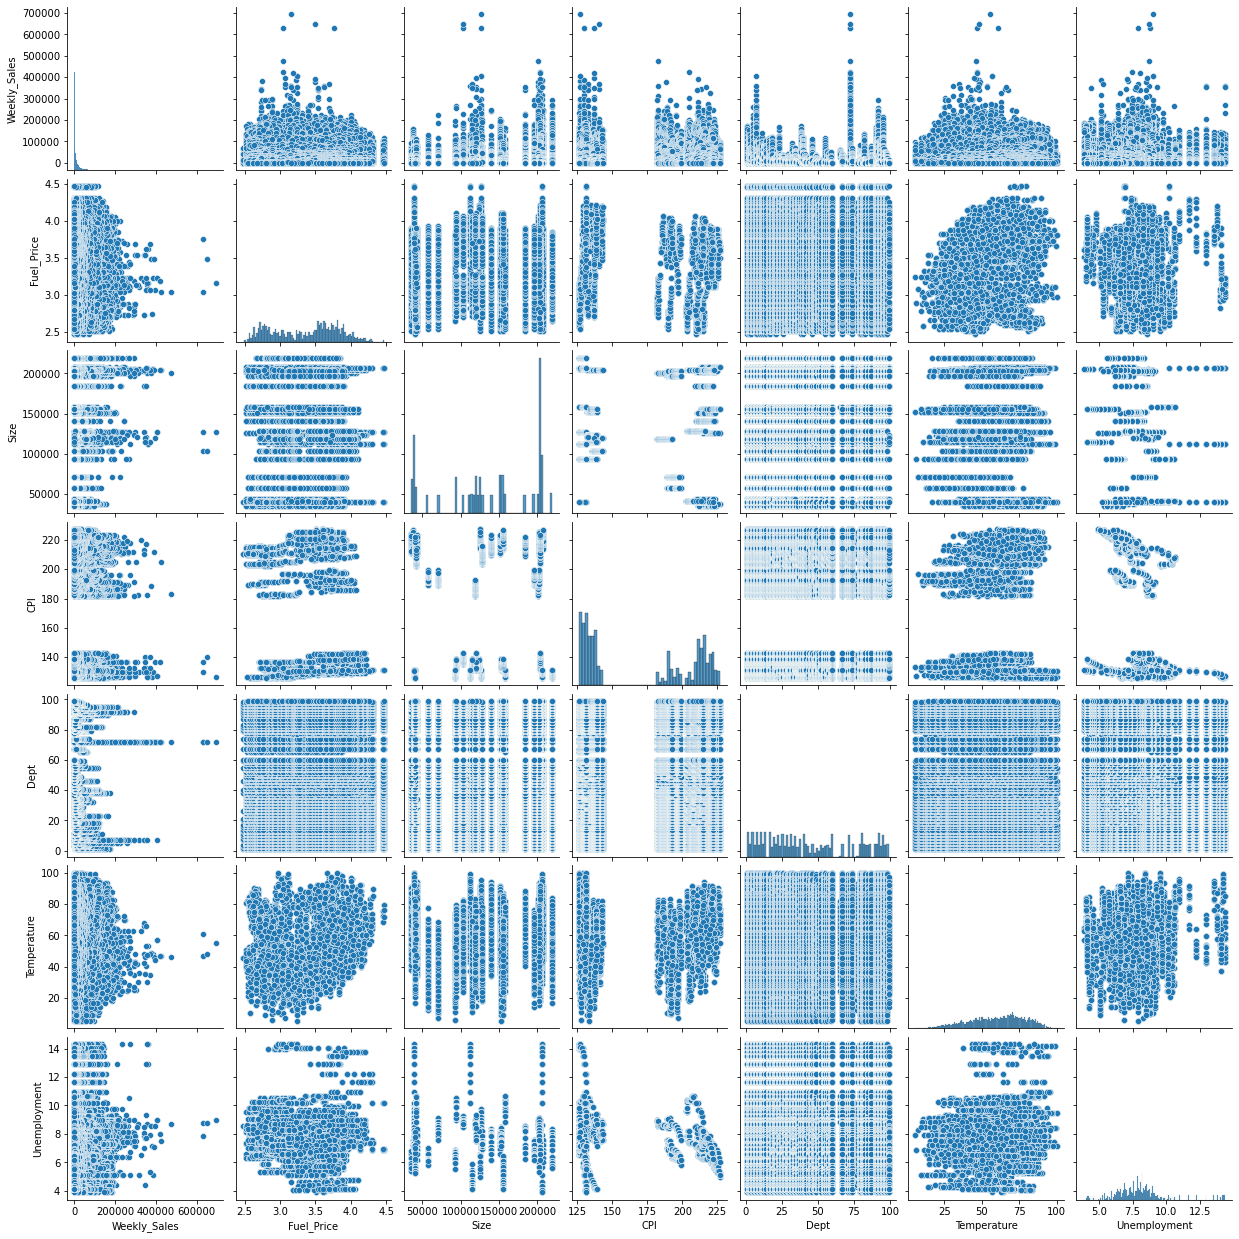

In [35]:
sns.pairplot(data, vars=['Weekly_Sales', 'Fuel_Price', 'Size', 'CPI', 'Dept', 'Temperature', 'Unemployment'])

In [ ]:
sns.pairplot(data.fillna(0), vars=['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

### 结论及其解释

In [ ]:
##  分析结论

In [ ]:
##  分析结果的商业解释

###  商务应用前景

### 伦理道德方面的思考